In [1]:
################################################################################
# STEP 1: MINIMAL DECISION-MAKING SNN (NO LEARNING YET)
#
# Goal:
#   - Clean framework
#   - Two excitatory pools: Left vs Right
#   - Shared inhibition
#   - Poisson sensory input
#   - Winner-take-all decision
#
# Next steps (after confirming it runs):
#   Step 2: Add STDP traces (pre & post)
#   Step 3: Add eligibility traces
#   Step 4: Add reward-modulated learning
################################################################################

from brian2 import *
import numpy as np


In [2]:
################################################################################
# Simulation parameters
################################################################################

defaultclock.dt = 0.1 * ms  # time resolution
trial_duration = 500 * ms  # stimulus period
rest_duration = 200 * ms  # recovery period
N_trials = 10  # number of trials (no learning yet)

################################################################################
# Neuron model: LIF
################################################################################

tau = 20 * ms
El = -65 * mV
Vt = -50 * mV
Vr = -65 * mV

# --- STDP / trace parameters (for step 2) ---
tau_pre = 20 * ms  # decay for pre-synaptic trace
tau_post = 20 * ms  # decay for post-synaptic trace
A_plus = 0.01  # used later for STDP/elig, leave as a constant now
A_minus = 0.012

eqs = """
dv/dt = (El - v + I_syn) / tau : volt (unless refractory)
I_syn : volt                     # synaptic input current
"""

################################################################################
# Populations
################################################################################

N_E = 50  # excitatory neurons per decision pool
N_I = 40  # inhibitory neurons

E_left = NeuronGroup(
    N_E,
    eqs,
    threshold="v > Vt",
    reset="v = Vr",
    refractory=2 * ms,
    method="euler",
    name="E_left",
)
E_right = NeuronGroup(
    N_E,
    eqs,
    threshold="v > Vt",
    reset="v = Vr",
    refractory=2 * ms,
    method="euler",
    name="E_right",
)
I_pop = NeuronGroup(
    N_I,
    eqs,
    threshold="v > Vt",
    reset="v = Vr",
    refractory=2 * ms,
    method="euler",
    name="I_pop",
)

# initialize membrane potentials
E_left.v = Vr
E_right.v = Vr
I_pop.v = Vr

################################################################################
# Poisson sensory input
################################################################################

N_in = 40
rate_base = 5 * Hz
rate_stim = 30 * Hz

input_left = PoissonGroup(N_in, rates=rate_base, name="input_left")
input_right = PoissonGroup(N_in, rates=rate_base, name="input_right")

################################################################################
# Synapses
################################################################################
# Reset Brian2 network state to remove old synapses
start_scope()

# model string for synapses with pre/post traces (no weight plasticity yet)
syn_model_traces = """
dpre_trace/dt = -pre_trace/tau_pre : 1 (event-driven)
dpost_trace/dt = -post_trace/tau_post : 1 (event-driven)
"""

on_pre_with_trace = """
I_syn_post += 0.5*mV       # same current magnitude you used before
pre_trace += 1.0
"""
on_post_with_trace = """
post_trace += 1.0
"""

# Input -> Left (with pre/post trace bookkeeping)
S_in_L = Synapses(
    input_left,
    E_left,
    model=syn_model_traces,
    on_pre=on_pre_with_trace,
    on_post=on_post_with_trace,
    name="S_in_L",
)
S_in_L.connect(p=0.3)
S_in_L.pre_trace = 0.0
S_in_L.post_trace = 0.0

# Input -> Right
S_in_R = Synapses(
    input_right,
    E_right,
    model=syn_model_traces,
    on_pre=on_pre_with_trace,
    on_post=on_post_with_trace,
    name="S_in_R",
)
S_in_R.connect(p=0.3)
S_in_R.pre_trace = 0.0
S_in_R.post_trace = 0.0

# Recurrent Left (E->E)
# use a slightly smaller on_pre current to avoid runaway firing if desired
S_rec_L = Synapses(
    E_left,
    E_left,
    model=syn_model_traces,
    on_pre="I_syn_post += 0.4*mV\npre_trace += 1.0",
    on_post="post_trace += 1.0",
    name="S_rec_L",
)
S_rec_L.connect(p=0.1)
S_rec_L.pre_trace = 0.0
S_rec_L.post_trace = 0.0

# Recurrent Right (E->E)
S_rec_R = Synapses(
    E_right,
    E_right,
    model=syn_model_traces,
    on_pre="I_syn_post += 0.4*mV\npre_trace += 1.0",
    on_post="post_trace += 1.0",
    name="S_rec_R",
)
S_rec_R.connect(p=0.1)
S_rec_R.pre_trace = 0.0
S_rec_R.post_trace = 0.0


# Lateral inhibition
S_EI_L = Synapses(E_left, I_pop, on_pre="I_syn_post += 1.0*mV", name="S_EI_L")
S_EI_L.connect(p=0.2)

S_EI_R = Synapses(E_right, I_pop, on_pre="I_syn_post += 1.0*mV", name="S_EI_R")
S_EI_R.connect(p=0.2)

S_IE_L = Synapses(I_pop, E_left, on_pre="I_syn_post -= 1.5*mV", name="S_IE_L")
S_IE_L.connect(p=0.2)

S_IE_R = Synapses(I_pop, E_right, on_pre="I_syn_post -= 1.5*mV", name="S_IE_R")
S_IE_R.connect(p=0.2)

In [3]:
################################################################################
# Monitors
################################################################################

ML = SpikeMonitor(E_left, name="ML")
MR = SpikeMonitor(E_right, name="MR")

rateL = PopulationRateMonitor(E_left, name="rateL")
rateR = PopulationRateMonitor(E_right, name="rateR")


In [4]:
################################################################################
# Trial function (NO LEARNING YET)
################################################################################


def run_trial(stim):
    """
    stim: 'L' or 'R' — which side receives high-rate Poisson input
    """
    if stim == "L":
        input_left.rates = rate_stim
        input_right.rates = rate_base
    else:
        input_left.rates = rate_base
        input_right.rates = rate_stim

    t_start = defaultclock.t
    run(trial_duration)
    t_end = defaultclock.t

    # count spikes only within this trial window
    L_count = np.sum((ML.t > t_start) & (ML.t <= t_end))
    R_count = np.sum((MR.t > t_start) & (MR.t <= t_end))

    choice = "L" if L_count > R_count else "R"
    return choice, L_count, R_count


In [5]:
################################################################################
# MAIN LOOP (no learning)
################################################################################
from tqdm import tqdm
for t in tqdm(range(N_trials)):

    # random stimulus
    stim = "L" if np.random.rand() < 0.5 else "R"

    # reset voltages between trials
    E_left.v = Vr
    E_right.v = Vr
    I_pop.v = Vr

    choice, L_count, R_count = run_trial(stim)

    print(
        f"Trial {t+1:2d}: stim={stim}, choice={choice}, "
        f"Lspk={L_count}, Rspk={R_count}"
    )

    # baseline during rest
    input_left.rates = rate_base
    input_right.rates = rate_base
    run(rest_duration)


  0%|          | 0/10 [00:00<?, ?it/s]WARNING    'S_rec_R' has been included in the network but not the object on which it depends.Setting 'S_rec_R' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'S_in_R' has been included in the network but not the object on which it depends.Setting 'S_in_R' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'rateL' has been included in the network but not the object on which it depends.Setting 'rateL' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'rateR' has been included in the network but not the object on which it depends.Setting 'rateR' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'S_EI_L' has been included in the network but not the object on which it depends.Setting 'S_EI_L' to inactive. [brian2.core.magic.dependency_warning]
WARNING    'S_EI_R' has been included in the network but not the object on which it depends.Setting 'S_EI_R' to inactive. [brian2.core.magic.dependency_warning

Trial  1: stim=R, choice=R, Lspk=0, Rspk=0
Trial  2: stim=R, choice=R, Lspk=0, Rspk=0


 30%|███       | 3/10 [00:00<00:01,  3.64it/s]

Trial  3: stim=L, choice=R, Lspk=0, Rspk=0
Trial  4: stim=L, choice=R, Lspk=0, Rspk=0


 50%|█████     | 5/10 [00:01<00:01,  4.39it/s]

Trial  5: stim=L, choice=R, Lspk=0, Rspk=0
Trial  6: stim=L, choice=R, Lspk=0, Rspk=0


 70%|███████   | 7/10 [00:01<00:00,  4.60it/s]

Trial  7: stim=R, choice=R, Lspk=0, Rspk=0
Trial  8: stim=R, choice=R, Lspk=0, Rspk=0


 90%|█████████ | 9/10 [00:02<00:00,  4.77it/s]

Trial  9: stim=R, choice=R, Lspk=0, Rspk=0
Trial 10: stim=L, choice=R, Lspk=0, Rspk=0


100%|██████████| 10/10 [00:02<00:00,  4.24it/s]


INFO       width adjusted from 5. ms to 5.1 ms [brian2.monitors.ratemonitor.adjusted_width]


ValueError: v cannot be empty

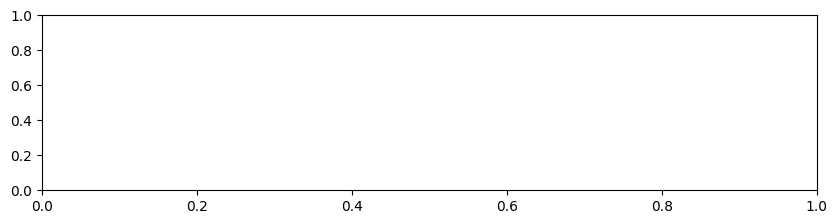

In [6]:

################################################################################
# PLOTS
################################################################################

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(rateL.t / ms, rateL.smooth_rate(window="flat", width=5 * ms) / Hz)
plt.plot(rateR.t / ms, rateR.smooth_rate(window="flat", width=5 * ms) / Hz)
plt.title("Population Rates (Left & Right)")
plt.ylabel("Hz")

plt.subplot(2, 1, 2)
plt.plot(ML.t / ms, ML.i, ".", ms=2, label="Left")
plt.plot(MR.t / ms, MR.i + N_E + 2, ".", ms=2, label="Right")
plt.title("Spike Raster")
plt.xlabel("Time (ms)")

plt.tight_layout()
plt.show()